In [1]:
# setup
from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))
display(HTML(open('rise.css').read()))

# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.5, rc={'figure.figsize':(12, 6)})


/var/folders/hr/xk7y44053qvd12l_1mpwdnk40000gn/T/ipykernel_49018/1435612826.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display,HTML


# CMPS 2200
# Introduction to Algorithms

## Parallelism (Cont'd)


## Example: Summing a list

Summing can easily be parallelised by splitting the input list into two (or $k$) pieces.

#### Sequential Version 

```python 

def sum_list(mylist):
    result = 0
    for v in mylist:
        result += v
    return result

sum_list(range(10))

```

<br>

> <span style="color:red">**Question**</span>:  What is the time cost? [It means the input length is $n$]



####  Paralell Version

```python

from multiprocessing.pool import ThreadPool

def in_parallel(f1, arg1, f2, arg2):
    with ThreadPool(2) as pool:
        result1 = pool.apply_async(f1, [arg1])  # launch f1
        result2 = pool.apply_async(f2, [arg2])  # launch f2
        return (result1.get(), result2.get())   # wait for both to finish

def parallel_sum_list(mylist):
    result1, result2 = in_parallel(
        sum_list, mylist[:len(mylist)//2],
        sum_list, mylist[len(mylist)//2:]
    )
    # combine results
    return result1 + result2

parallel_sum_list(list(range(10)))

```



The **speedup** of a parellel algorithm $P$ over a sequential algorithm $S$ is:
$$
\text{speedup}(P,S) = \frac{T(S)}{T(P)} 
$$



### Dependency

> The fundamental challenge of parallel algorithms is that computations must be **independent** to be performed in parallel.  Parallel computations should not depend on each other.

**What should this code output?**

```python

total = 0

def count(size):
    global total
    for _ in range(size):
        total += 1

def race_condition_example():
    global total
    in_parallel(count, 100000,
                count, 100000)
    print(total)

race_condition_example()

```

#### Counting in parallel is hard!

- motivates functional programming (next class)

This course will focus on:
- understanding when things can run in parallel and when they cannot
- algorithm, not hardware specifics (though see CMPS 4760: Distributed Systems)

<br>

<span style="color:red">**Question**</span>: How can we compare two parallel algorithms?

## Analyzing parallel algorithms

> **work**: total number of primitive operations performed by an algorithm


- For sequential machine, just total sequential time. 
- On parallel machine, work is divided among $P$ processors

<br>

- e.g., <span style="color:red">**parallel_sum_list**</span>: input list $a$ ($n$ elements) $\rightarrow$ ($a_1$, $a_2$) to a machine with 2 processors [increase to 4 processors or more]



> **perfect speedup**: dividing $W$ work across $P$ processors yields total time $\frac{W}{P}$

> Unfortunately, we cannot achieve this. <span style="color:red">**Why?**</span>

> **span**: longest sequence of dependencies in computation
- time to run with an infinite number of processors
- measure of how "parallelized" an algorithm is
- also called: **critical path length** or **computational depth**


## More Intuition

>**work**: $T_1$ = time using one processor  
>**span**: $T_\infty$ = time using $\infty$ processors


>**work**: total energy consumed by a computation  
>**span**: minimum possible time that the computation requires


> **parallelism** = $\frac{T_1}{T_\infty}$  
>  <span style="color:red">**maximum**</span> possible speedup with unlimited processors

Summing can easily be parallelised by splitting the input list into two (or $k$) pieces.

> [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


**What is work and span of `parallel_sum_list` algorithm using $n$ threads?**


In [4]:
def in_parallel_n(tasks):
    """
    generalize in_parallel for n threads.
    
    Params:
      tasks: list of (function, argument) tuples to run in parallel
      
    Returns:
      list of results
    """
    with ThreadPool(len(tasks)) as pool:
        results = []
        for func, arg in tasks:
            results.append(pool.apply_async(func, [arg]))
        return [r.get() for r in results]


def parallel_n_sum_list(mylist):
    results = in_parallel_n([ (sum_list, [v]) for v in mylist ])
    # combine results...looks familiar...
    result = 0
    for v in results:
        result += v
    return result

parallel_n_sum_list(range(10))

45

- work: $\mathcal{O}(n)$
- span: $\mathcal{O}(n)$


**oops** that didn't work...

<br>

can we do better?

**Idea: Recursive Algorithm**
- let threads create threads recursively [**Example**:] https://www.programiz.com/python-programming/recursion

- parallelize combination steps


## Divide-and-Conquer

![dag-sum](figures/dag-sum.png)  
[source](https://homes.cs.washington.edu/~djg/teachingMaterials/spac/sophomoricParallelismAndConcurrency.pdf)


In [ ]:
# recursive, serial
def sum_list_recursive(mylist):
    print('summing %s' % mylist)
    if len(mylist) == 1:
        return mylist[0]
    return (
        sum_list_recursive(mylist[:len(mylist)//2]) +
        sum_list_recursive(mylist[len(mylist)//2:])
    )

sum_list_recursive(range(10))

In [ ]:
# recursive, parallel
def sum_list_recursive_parallel(mylist):
    print('summing %s' % mylist)
    if len(mylist) == 1:
        return mylist[0]

    # each thread spawns more threads
    result1, result2 = in_parallel(
        sum_list_recursive_parallel, mylist[:len(mylist)//2],
        sum_list_recursive_parallel, mylist[len(mylist)//2:]
    )
    print('>>>merging %s and %s' % (result1, result2))
    return result1 + result2

sum_list_recursive_parallel(range(10))

## Computation Graph

![dag](figures/dag.png)  
[source](https://homes.cs.washington.edu/~djg/teachingMaterials/spac/sophomoricParallelismAndConcurrency.pdf)

- Directed-acyclic graph (DAG) where
  - Each node is a unit of computation $(\mathcal{O}(1))$
  - An edge is a **computational dependency**
    - Edge from node $A$ and $B$ means $A$ must complete before $B$ begins
    
> **work**: total number of primitive operations performed by an algorithm  
> **span**: longest sequence of dependencies in computation



#### So, what is work and span for `sum_list_recursive_parallel`?

**work**: number of nodes

**span**: length of longest path

What is the height of a balanced binary tree with $n$ nodes?

> $\mathcal{O}(\log_2 n)$


- Number of leaf nodes in a perfect binary tree is $2^h$.
- To add an array of length $n$, the computation graph has $2 * 2^{(\log_2 n)} = 2n$ nodes.

<br>

so,

**work**: $2n \in \mathcal{O}(n)$  
**span**: $2 \log_2 n \in \mathcal{O}(\log_2 n)$

<br>

**parallelism**: $\mathcal{O}(\frac{n}{\log_2 n})$ = **exponential speedup**




### Work Efficiency

> A parallel algorithm is (asymptotically) **work efficient** if the work is asymptotically the same as the time for an optimal sequential algorithm that solves the same problem.

Since $T_{\hbox{sequential}} = T_1 = \mathcal{O}(n)$, our parallel algorithm is work efficient

## Using $p$ processors

Of course, we don't have $\infty$ processors. What if we only have $p$?

It can be shown that:

$$T_p \leq \frac{T_1}{p} + T_\infty$$ or $$T_p \in \mathcal{O}(\frac{T_1}{p} + T_\infty)$$

So, assuming $\log_2 n$ processors, our parallel sum algorithm has time

$\mathcal{O}(\frac{n}{\log_2 n} + \log_2 n)$

compared to $\mathcal{O}(n)$ of serial algorithm.



## Amdahl's Law

As seen above, some parts of parallel algorithms are sequential.

We expect that the bigger the "sequential" part of the parallel algorithm is, the lower its speedup.

How bad is a little bit of sequential code?


- Let $T_1$ be the total time of the parallel algorithm on one processor. Let's set this value to 1.
- Let $S$ be the amount of time that cannot be parallelized.
- Assume (generously) that the remaining time (1-S) gets perfect speedup using $p$ processors.
- Then we have

$T_1 = S + (1-S) = 1$  
$T_P = S + \frac{(1-S)}{p}$


<br><br>
**Amdahl's Law**

$$\frac{T_1}{T_p} = \frac{1}{S + \frac{1 − S}{p}}$$

speedup using $p$ processors is limited by the fraction of the algorithm that is parallelizable.

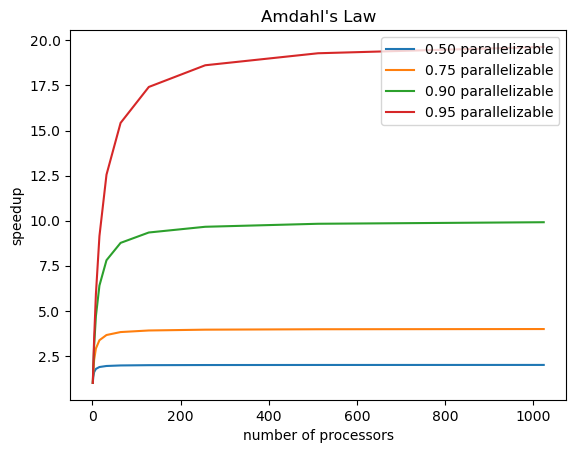

In [5]:
# plot amdahl's law
import matplotlib.pyplot as plt

processors = [1,2,4,8,16,32,64,128,256,512,1024]
parallel_portions = [.5, .75, .9, .95]
plt.figure()
for parallel_portion in parallel_portions:
    S = 1 - parallel_portion
    speedups = [1 / (S + (1-S)/p) for p in processors]
    plt.plot(processors, speedups, label='%.2f parallelizable' % parallel_portion)
plt.legend()
plt.ylabel('speedup')
plt.xlabel('number of processors')
plt.title("Amdahl's Law")
plt.show()


If 95% of the program can be parallelized, the theoretical maximum speedup using parallel computing would be 20 times.

If 50% of the program can be parallelized, the theoretical maximum speedup using parallel computing would be 2 times.

**even if you have a billion processors!**

**Reasons for hope:**

As number of processors grow, span becomes more important than work.
- scalability matters more than performance
- we can tradeoff work and span in algorithm choice

Allows us to do new things we couldn't do before:
- consider **computer graphics**: rendering many pixels in parallel allows more accurate images